--------------------------------------------------------------------------------
Travel time calculation using AnalyticalWell class, combined with 'omp removal'
--------------------------------------------------------------------------------

Basic example to calculate the travel time distribution per geological layer for a 
phreatic scheme, and to calculate the OMP removal. 

Import packages
-----------------

First we import the necessary python packages

In [403]:
import pandas as pd
from pathlib import Path
from set_cwd_to_project_root import project_root

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from pandas import read_csv
from pandas import read_excel
import math
from scipy.special import kn as besselk
import sutra2.Analytical_Well as AW
import sutra2.ModPath_Well as mpw
import sutra2.Transport_Removal as TR

import warnings 
warnings.filterwarnings(action= 'ignore')

# # get directory of this file
# path = Path(__file__).parent
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Step 1: Define the HydroChemicalSchematisation
-----------------------------------------------
The first step is to define the hydrogeochemistry of the system using the HydroChemicalSchematisation class.
In this class you specify the:

* Computational method ('analytical' or 'modpath').
* The schematisation type ('phreatic', 'semiconfined',...) 
note: schematisation types 'riverbankfiltration', 'basinfiltration' yet to be supported
* Input the relevant parameters for the porous media, the hydrochemistry, hydrology and the flow parameters of interest

The class parameters can be roughly grouped into the following categories:

* System.
* Settings.
* Porous Medium
* Hydrochemistry
* Hydrology
* Diffuse contamination
* Point Contamination
* Model size

Units of input are:

* Discharge : m3/d
* Time: days
* Length: meters
* Concentration: ug/L
* Temperature: degree C
* Depth: meters above sea level (m ASL)
* Density: kg/L
* DOC/TOC: mg/L

Lets start with a simple example defining a HydroChemicalSchematisation object for a phreatic aquifer:


In [404]:
phreatic_schematisation = AW.HydroChemicalSchematisation(schematisation_type='phreatic',
                                                    computation_method='analytical',
                                                    well_discharge=-7500, #m3/day
                                                    recharge_rate=0.0008, #m/day
                                                    thickness_vadose_zone_at_boundary=5, #m
                                                    thickness_shallow_aquifer=10,  #m
                                                    thickness_target_aquifer=40, #m
                                                    hor_permeability_target_aquifer=35, #m/day
                                                    redox_vadose_zone='anoxic',
                                                    redox_shallow_aquifer='anoxic',
                                                    redox_target_aquifer='deeply_anoxic',
                                                    pH_target_aquifer=7.,
                                                    temp_water=11.,
                                                    diffuse_input_concentration = 100, #ug/L
                                                    )


The parameters from the HydroChemicalSchematisation class are added as attributes to
the class and can be accessed for example:

In [405]:
print(phreatic_schematisation.schematisation_type)
print(phreatic_schematisation.well_discharge)
print(phreatic_schematisation.porosity_shallow_aquifer)

phreatic
-7500
0.35


If not defined, default values are used for the rest of the parameters. To view all parameters in the schematisation:

In [406]:
phreatic_schematisation.__dict__

{'schematisation_type': 'phreatic',
 'computation_method': 'analytical',
 'removal_function': 'omp',
 'what_to_export': 'all',
 'well_name': 'well1',
 'temp_correction_Koc': True,
 'temp_correction_halflife': True,
 'biodegradation_sorbed_phase': True,
 'compute_thickness_vadose_zone': True,
 'ground_surface': 0.0,
 'thickness_vadose_zone_at_boundary': 5,
 'bottom_vadose_zone_at_boundary': -5.0,
 'thickness_shallow_aquifer': 10,
 'bottom_shallow_aquifer': -15.0,
 'thickness_target_aquifer': 40,
 'bottom_target_aquifer': -55.0,
 'thickness_full_capillary_fringe': 0.0,
 'porosity_vadose_zone': 0.35,
 'porosity_shallow_aquifer': 0.35,
 'porosity_target_aquifer': 0.35,
 'porosity_gravelpack': 0.35,
 'porosity_clayseal': 0.35,
 'moisture_content_vadose_zone': 0.2,
 'solid_density_vadose_zone': 2.65,
 'solid_density_shallow_aquifer': 2.65,
 'solid_density_target_aquifer': 2.65,
 'fraction_organic_carbon_vadose_zone': 0.001,
 'fraction_organic_carbon_shallow_aquifer': 0.0005,
 'fraction_organ

____________________________________


Step 2: Run the AnalyticalWell class
-------------------------------------
Next we create an AnalyticalWell object for the HydroChemicalSchematisation object we just made.


In [407]:
phreatic_well = AW.AnalyticalWell(phreatic_schematisation)

Then we calculate the travel time for each of the zones unsaturated, shallow aquifer and target aquifer zones
by running the .phreatic() function for the well object. 

In [408]:
phreatic_well.phreatic()

From the AnalyticalWell class two other important outputs are:

* df_particle - Pandas dataframe with data about the different flowlines per zone (unsaturated/shallow/target)
* df_flowline - Pandas dataframe with data about the flowlines per flowline (eg. total travel time per flowline)


In [409]:
print(phreatic_well.df_particle.head(4))

   flowline_id             zone  travel_time total_travel_time    xcoord  \
1            1          surface            0                 0  5.462742   
1            1      vadose_zone  2477.012721       2477.012721  5.462742   
1            1  shallow_aquifer  2227.727738       4704.740459  5.462742   
1            1   target_aquifer     0.175001        4704.91546  0.375000   

  ycoord  zcoord          redox  temp_water  travel_distance  porosity  \
1      1     0.0         anoxic        11.0              NaN       NaN   
1      1    -5.0         anoxic        11.0        -9.908051      0.35   
1      1   -15.0         anoxic        11.0        24.908051      0.35   
1      1   -55.0  deeply_anoxic        11.0         5.462742      0.35   

   dissolved_organic_carbon   pH  fraction_organic_carbon  solid_density  
1                       NaN  NaN                      NaN            NaN  
1                       0.0  7.0                   0.0010           2.65  
1                      

In [410]:
print(phreatic_well.df_flowline.head(2))

   flowline_id   flowline_type flowline_discharge particle_release_day  \
1            1  diffuse_source              0.075                 None   
2            2  diffuse_source              0.675                 None   

  endpoint_id  well_discharge removal_function  
1       well1            7500              omp  
2       well1            7500              omp  



____________________________________


Step 3: Collect removal parameters for the OMP (substance)
------------------------------------------------------------

You can retrieve the default removal parameters used to calculate the removal of organic micropollutants [OMP] 
in the SubstanceTransport class. The data are stored in a dictionary


In [411]:
test_substance = TR.Substance(substance_name='benzene')
test_substance.substance_dict

{'substance_name': 'benzene',
 'log_Koc': 1.92,
 'molar_mass': 78.1,
 'pKa': 99,
 'omp_half_life': {'suboxic': 10.5, 'anoxic': 420, 'deeply_anoxic': 1e+99}}

To obtain a list of Substances included in the Substance class, see substance_database

In [412]:
for key, val in test_substance.substance_database.items():
    print(key,"\n",val,"\n")

benzene 
 {'substance_name': 'benzene', 'log_Koc': 1.92, 'molar_mass': 78.1, 'pKa': 99, 'omp_half_life': {'suboxic': 10.5, 'anoxic': 420, 'deeply_anoxic': 1e+99}} 

AMPA 
 {'substance_name': 'AMPA', 'log_Koc': -0.36, 'molar_mass': 111.04, 'pKa': 0.4, 'omp_half_life': {'suboxic': 46, 'anoxic': 46, 'deeply_anoxic': 1e+99}} 

benzo(a)pyrene 
 {'substance_name': 'benzo(a)pyrene', 'log_Koc': 6.43, 'molar_mass': 252.3, 'pKa': 99, 'omp_half_life': {'suboxic': 530, 'anoxic': 2120, 'deeply_anoxic': 2120}} 

OMP-X 
 {'substance_name': 'OMP-X', 'log_Koc': 0, 'molar_mass': 100, 'pKa': 99, 'omp_half_life': {'suboxic': 1e+99, 'anoxic': 1e+99, 'deeply_anoxic': 1e+99}} 



Optional: You may specify a different value for the substance parameters, for example
a different half-life for the anoxic redox zone. This can be input in the Transport class
and this will be used in the calculation for the removal of the OMP. 

In [413]:
# Define removal parameters of pollutant
substance_benzene = TR.Substance(substance_name = 'benzene',
                                partition_coefficient_water_organic_carbon=2,
                                molar_mass = 78.1,
                                dissociation_constant=1,
                                halflife_suboxic=12, 
                                halflife_anoxic=420, 
                                halflife_deeply_anoxic=6000)

If you have specified values for the substance (e.g. half-life, pKa, log_Koc),
the default value is overwritten and used in the calculation of the removal. You can
view the updated substance dict ('substance dictionary') from the concentration object

In [414]:
substance_benzene.substance_dict

{'substance_name': 'benzene',
 'log_Koc': 2,
 'molar_mass': 78.1,
 'pKa': 1,
 'omp_half_life': {'suboxic': 12, 'anoxic': 420, 'deeply_anoxic': 6000}}

> Note: for microbial organisms call the MicrobialOrganism class.
> See example for AnalyticalWell plus mbo removal.
> 
> test_organism = TR.MicrobialOrganism(organism_name='MS2')
> test_organism.organism_dict

____________________________________


Step 4: Run the Transport class
--------------------------------
To calculate the removal and the steady-state concentration in each zone, create a concentration
object by running the Transport class with the phreatic_well object and specifying
the OMP (or pathogen) of interest.

In this example we use benzene. First we create the object and view the substance properties:

In [415]:
phreatic_transport = TR.Transport(well = phreatic_well, pollutant = test_substance)
phreatic_transport.removal_parameters

{'substance_name': 'benzene',
 'log_Koc': 1.92,
 'molar_mass': 78.1,
 'pKa': 99,
 'omp_half_life': {'suboxic': 10.5, 'anoxic': 420, 'deeply_anoxic': 1e+99}}

Then we can compute the removal by running the 'compute_omp_removal' function:

In [416]:
phreatic_transport.compute_omp_removal()

Once the removal has been calculated, you can view the steady-state concentration
and breakthrough time per zone for the OMP in the df_particle:

In [417]:
phreatic_transport.df_particle.loc[:,['zone', 'steady_state_concentration', 'travel_time']]

,zone,steady_state_concentration,travel_time
1,surface,100,0
1,vadose_zone,5.024012,2477.012721
1,shallow_aquifer,0.58186,2227.727738
1,target_aquifer,0.58186,0.175001
2,surface,100,0
...,...,...,...
104,target_aquifer,0.320597,92720.553915
105,surface,100,0
105,vadose_zone,22.105099,1250.010658
105,shallow_aquifer,0.320515,4374.981348


View the steady-state concentration of the flowline or the steady-state
contribution of the flowline to the concentration in the well

In [418]:
phreatic_transport.df_flowline.loc[:,['breakthrough_concentration', 'total_breakthrough_travel_time']].head(5)


,breakthrough_concentration,total_breakthrough_travel_time
1,0.581860,16618
2,0.516445,16702
3,0.458384,16805
4,0.421722,16956
5,0.406851,17098


Plot the breakthrough curve at the well over time:

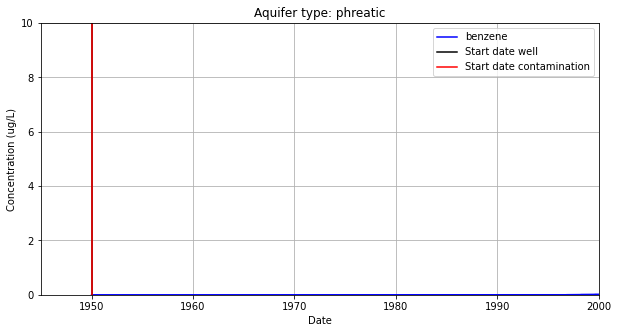

In [419]:
benzene_plot = phreatic_transport.plot_concentration(ylim=[0,10 ])

You can also compute the removal for a different OMP of interest:

* OMP-X: a ficticous OMP with no degradation or sorption
* AMPA
* benzo(a)pyrene

To do so you can use the original schematisation, but specify a different OMP when you create
the Transport object.

In [420]:
# phreatic_well = AW.AnalyticalWell(phreatic_schematisation)
phreatic_well.phreatic() 
# removal parameters OMP-X (default)
substance_ompx = TR.Substance(substance_name = "OMP-X")
print(substance_ompx.substance_dict)
# Transport object
phreatic_transport = TR.Transport(phreatic_well, pollutant = substance_ompx)
phreatic_transport.compute_omp_removal()


{'substance_name': 'OMP-X', 'log_Koc': 0, 'molar_mass': 100, 'pKa': 99, 'omp_half_life': {'suboxic': 1e+99, 'anoxic': 1e+99, 'deeply_anoxic': 1e+99}}


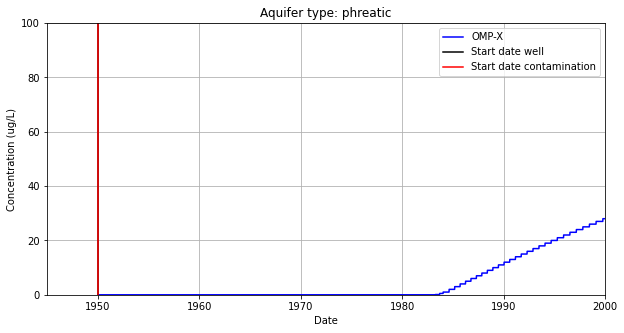

In [421]:

# Plot the breakthrough concentration
omp_x_plot = phreatic_transport.plot_concentration(ylim=[0,100 ])


In [422]:
# phreatic_well = AW.AnalyticalWell(phreatic_schematisation)
phreatic_well.phreatic() 

# removal parameters benzo(a)pyrene (default)
substance_benzpy = TR.Substance(substance_name = "benzo(a)pyrene")
print(substance_benzpy.substance_dict)
# Transport object
phreatic_transport = TR.Transport(phreatic_well, pollutant = substance_benzpy)
phreatic_transport.compute_omp_removal()


{'substance_name': 'benzo(a)pyrene', 'log_Koc': 6.43, 'molar_mass': 252.3, 'pKa': 99, 'omp_half_life': {'suboxic': 530, 'anoxic': 2120, 'deeply_anoxic': 2120}}


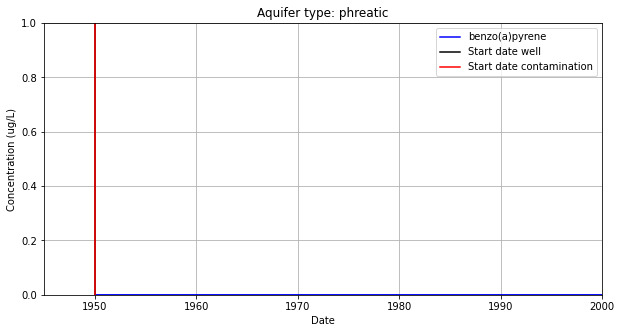

In [423]:

benzo_plot = phreatic_transport.plot_concentration(ylim=[0,1])


In [424]:
# phreatic_well = AW.AnalyticalWell(phreatic_schematisation)
phreatic_well.phreatic() 
# removal parameters AMPA (default)
substance_ampa = TR.Substance(substance_name = "AMPA")
print(substance_ampa.substance_dict)
# Transport object
phreatic_concentration = TR.Transport(phreatic_well, pollutant = substance_ampa)
phreatic_concentration.compute_omp_removal()


{'substance_name': 'AMPA', 'log_Koc': -0.36, 'molar_mass': 111.04, 'pKa': 0.4, 'omp_half_life': {'suboxic': 46, 'anoxic': 46, 'deeply_anoxic': 1e+99}}


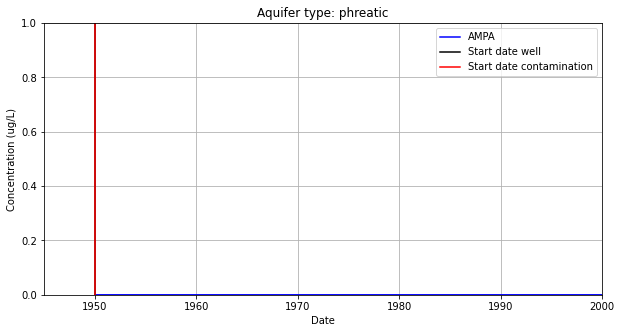

In [425]:

ampa_plot = phreatic_concentration.plot_concentration( ylim=[0,1])


The total travel time can be plotted as a function of radial distance from the well, or as a function
of the cumulative fraction of abstracted water: 

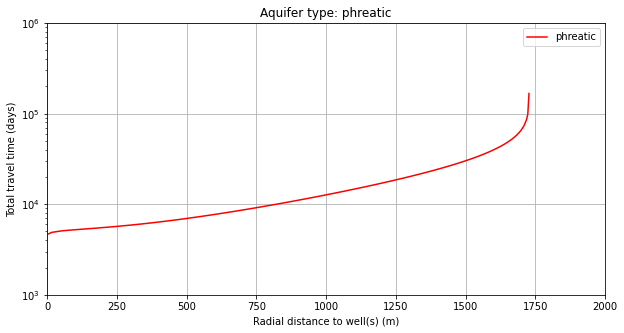

In [426]:
radial_plot = phreatic_well.plot_travel_time_versus_radial_distance(xlim=[0, 2000], ylim=[1e3, 1e6])


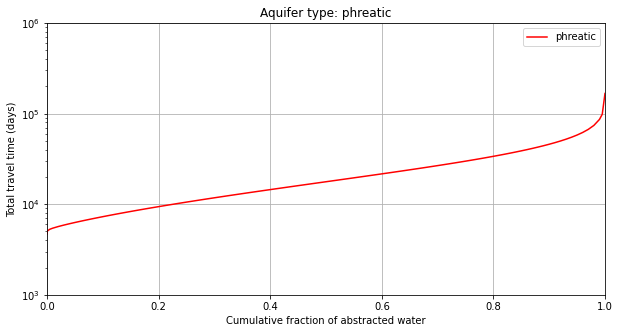

In [427]:
cumulative_plot = phreatic_well.plot_travel_time_versus_cumulative_abstracted_water(xlim=[0, 1], ylim=[1e3, 1e6])